# Lecture 21 Community Detection
This notebook will find communities in social networks using different methods

Below is the overview of this notebook.

<ol type = 1>
  <li> Find Modularity Communities</li>
  <li> Find Spectral Communities </li>
  <li> Find Text Based Communities </li>
  <li> Find Image Based Communities </li>
  <li> Find Communities with AI </li>
  <li> Targeted Content Based on Communities </li>

</ol>

This notebook can be opened in Colab
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/zlisto/social_media_analytics/blob/main/Lecture21_CommunityDetection.ipynb)

Before starting, select "Runtime->Factory reset runtime" to start with your directories and environment in the base state.

If you want to save changes to the notebook, select "File->Save a copy in Drive" from the top menu in Colab.  This will save the notebook in your Google Drive.


# Clones, Installs, and Imports


In [1]:
!git clone https://github.com/zlisto/social_media_analytics

import os
os.chdir("social_media_analytics")

Cloning into 'social_media_analytics'...
remote: Enumerating objects: 2837, done.
remote: Counting objects: 100% (248/248), done.
remote: Compressing objects: 100% (126/126), done.
remote: Total 2837 (delta 138), reused 230 (delta 122), pack-reused 2589
Receiving objects: 100% (2837/2837), 273.62 MiB | 27.08 MiB/s, done.
Resolving deltas: 100% (527/527), done.
Updating files: 100% (1980/1980), done.


## Installs

We will need `openai` and `umap`.

In [2]:
!pip install openai -q
!pip install umap-learn -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.8/292.8 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 5.7 MB/s eta 0:00:00


## Imports

In [3]:
import pandas as pd
import numpy as np
import os
import pickle
import json
import re
import textwrap as tr
import time

#image processing packages
import tensorflow as tf
import tensorflow_hub as hub
import requests
from PIL import Image
from io import BytesIO
import base64

#network analysis packages
import networkx as nx
import networkx.algorithms.community as nx_comm
from scripts.communities import spectral_communities

#plotting packages
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns
import plotly.express as px

#Low-dimensional embedding packages
from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.preprocessing import StandardScaler

#Clustering packages
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#OpenAI API
import openai

#Progress bar packages
from tqdm import tqdm
from tqdm import tqdm_notebook
tqdm_notebook().pandas()

#Display HTML files in Colab
from IPython.display import HTML

pd.set_option("display.max_colwidth", None)
plt.rcParams['figure.figsize'] = [8, 6]  # Width=8 inches, height=6 inches
plt.rc('axes', titlesize=18)
plt.rc('axes', labelsize=18)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)

<ipython-input-3-16dc774d7ed8>:45: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm_notebook().pandas()


0it [00:00, ?it/s]

## OpenAI API Key

You can get your OpenAI API key from https://platform.openai.com/api-keys.
Paste your key into the environment variable `"OPEN_API_KEY"`.  Then create a `client` that connects you to the OpenAI API.

In [4]:
os.environ['OPENAI_API_KEY'] = ''

OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

client = openai.Client(api_key=OPENAI_API_KEY)

#MODEL = 'gpt-3.5-turbo'
MODEL = 'gpt-4-turbo-preview'

## Helper Functions

You can put any custom functions you will need here so they do not clutter up your code.





In [5]:
def get_embedding(text, model="text-embedding-3-large"):
    text = text.replace("\n", " ")
    return client.embeddings.create(input = [text], model=model).data[0].embedding

def get_completion(prompt, instructions, client, model="gpt-3.5-turbo",
                   output_type = 'text'):
  '''Get a text completion from the OpenAI API'''
  completion = client.chat.completions.create(
                model=model,
                response_format={ "type": output_type},
                messages=[
                  {"role": "system", "content": instructions},
                  {"role": "user", "content": prompt}
                ]
              )
  response =completion.choices[0].message.content

  return response

def generate_image(prompt = "Draw a cute bunny", model = "dall-e-3"):
  '''Generates an image using the OpenAI API'''

  response_img = client.images.generate(
    model= model,
    prompt=prompt,
    size="1024x1024",
    quality="standard",
    n=1,
  )
  time.sleep(1)
  image_url = response_img.data[0].url
  revised_prompt = response_img.data[0].revised_prompt

  return image_url, revised_prompt

def generate_image_description(image_urls, instructions):
  '''Generates a description of a list of image_urls using the OpenAI Vision API'''
  PROMPT_MESSAGES = [
    {
        "role": "user",
        "content": [{"type": "text","text":instructions},
            *map(lambda x: {"type":"image_url","image_url": x}, image_urls),
        ],
    },
  ]
  params = {
      "model": "gpt-4-vision-preview",
      "messages": PROMPT_MESSAGES,
      "max_tokens": 1000,
  }

  response= client.chat.completions.create(**params)


  image_description = response.choices[0].message.content
  return image_description

def plot_image_embedding(df, col_x,col_y,
                         col_image_url,
                         image_zoom = 0.3,
                         max_size = 100):

  x = df[col_x]
  y = df[col_y]
  image_urls = df[col_image_url]

  fig, ax = plt.subplots(figsize = (10,10))
  ax.scatter(x, y)  # Plotting just for the base scatter plot

  for x0, y0, image_url in zip(x, y, image_urls):
    try:
      response = requests.get(image_url)
      img = Image.open(BytesIO(response.content))
      # Resize the image to 20 x 20 pixels
      img = img.resize((max_size, max_size))
      ab = AnnotationBbox(OffsetImage(img,
                                      zoom = image_zoom),
                          (x0, y0),
                          frameon=False)
      ax.add_artist(ab)
    except:
      pass

  return ax

def draw_ellipse(position, covariance, ax=None,
                 ellipse_scale=5, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()

    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = ellipse_scale * np.sqrt(s)
    else:
        angle = 0
        width, height = ellipse_scale * np.sqrt(covariance)

    # Draw the Ellipse
    for nsig in range(1, 2):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle = angle, **kwargs))

def display_tweet(text='life is good', screen_name='zlisto'):
    display_html = f'''
    <!DOCTYPE html>
    <html>
    <head>
        <style>
            .tweet {{
                background-color: white;
                color: black;
                border: 1px solid #e1e8ed;
                border-radius: 10px;
                padding: 20px;
                max-width: 500px;
                margin: 20px auto;
                font-family: 'Helvetica Neue', Helvetica, Arial, sans-serif;
                box-shadow: 0px 0px 10px rgba(0,0,0,0.1);
            }}
            .user strong {{
                color: #1da1f2;
            }}
            .tweet-text p {{
                margin: 0;
                line-height: 1.5;
            }}
        </style>
    </head>
    <body>
        <div class="tweet">
            <div class="user">
                <strong>@{screen_name}</strong>
            </div>
            <div class="tweet-text">
                <p>{text}</p>
            </div>
        </div>
    </body>
    </html>
    '''
    display(HTML(display_html))
    return display_html

def display_IG(caption, image_url, screen_name='zlisto', profile_image_url = None):
    response = requests.get(image_url)
    image_data = response.content
    # Encoding the image data as base64
    base64_image = base64.b64encode(image_data).decode('utf-8')
    # Generating HTML to display the image
    image_url_local = f'data:image/jpeg;base64,{base64_image}'

    ''' HTML template for displaying the image, screen name, and caption in an Instagram-like format'''

    display_html = f"""
    <style>
        .instagram-post {{
            border: 1px solid #e1e1e1;
            border-radius: 3px;
            width: 600px;
            margin: 20px auto;
            background-color: white;
            font-family: 'Helvetica Neue', Helvetica, Arial, sans-serif;
        }}
        .instagram-header {{
            padding: 14px;
            border-bottom: 1px solid #e1e1e1;
            display: flex;
            align-items: center;
        }}
        .instagram-profile-pic {{
            border-radius: 50%;
            width: 32px;
            height: 32px;
            margin-right: 10px;
        }}
        .instagram-screen-name {{
            font-weight: bold;
            color: #262626;
            text-decoration: none;
            font-size: 14px;
        }}
        .instagram-image {{
            max-width: 600px;
            width: auto;
            height: auto;
            display: block;
            margin: auto;
        }}
        .instagram-caption {{
            padding: 10px;
            font-size: 14px;
            color: #262626;
        }}
        .instagram-footer {{
            padding: 10px;
            border-top: 1px solid #e1e1e1;
        }}
        .instagram-likes {{
            font-weight: bold;
            margin-bottom: 8px;
        }}
    </style>
    <div class="instagram-post">
        <div class="instagram-header">
            <img src="{profile_image_url}" alt="Profile picture" class="instagram-profile-pic">
            <a href="#" class="instagram-screen-name">{screen_name}</a>
        </div>
        <img src="{image_url_local}" alt="Instagram image" class="instagram-image">
        <div class="instagram-caption">
            <a href="#" class="instagram-screen-name">{screen_name}</a> {caption}
        </div>
        <div class="instagram-footer">
            <div class="instagram-likes">24 likes</div>
            <!-- Include other footer content here -->
        </div>
    </div>
    """
    display(HTML(display_html))
    return display_html


# Load Network Data

The network data is saved in a file `"data/friends_network_JoeBiden.pickle"`.  We can load it into a networkx DiGraph (directed graph) object `G` with the `pickle.load` function.  

The `G.nodes` parameter lets us see the screen name of the nodes in the network.  We will then save all the screen names into a dataframe `df` in a column called `"screen_name"`.


There are a whole bunch of methods and parameters for a DiGraph in networkx.  You can find some of them here: https://networkx.org/documentation/stable/reference/index.html

In [37]:
#filename of follower network
screen_name = 'JoeBiden'
fname_following = f"data/friends_network_{screen_name}.pickle"

with open(fname_following , 'rb') as f:
  G = pickle.load(f)
  G.remove_node('JoeBiden')  #remove JoeBiden because its his network


df = pd.DataFrame({'username':[v for v in G.nodes]})

nv = G.number_of_nodes()
ne = G.number_of_edges()

print(f"Network has {nv} nodes\nNetwork has {ne} edges")
df.head()

Network has 26 nodes
Network has 113 edges


username
0  JoeForNV
1  JoeForSC
2  JoeForNH
3  JoeForIA
4   TeamJoe

# Modularity Communities

We will find communities by maximizing modularity.

## Find Modularity Communities

We will use the `modularity` function in networkx to find the modularity communities.  `modularity` returns a list of lists for the communities.  We will turn that into a column called `"community_mod"`  in `df`.  To get the number of communities, which we call `ncomm_mod`, we can use the `unique` function on the `"community_mod"` column.

In [7]:
Comm = nx_comm.greedy_modularity_communities(G.to_undirected())
C = []
V = []
for count,comm in enumerate(Comm):
    for v in comm:
        C.append(count)
        V.append(v)

df['community_mod'] = C
ncomm_mod = len(df.community_mod.unique())
print(f"{ncomm_mod} modularity communities")

df.head()



3 modularity communities


username  community_mod
0  JoeForNV              0
1  JoeForSC              0
2  JoeForNH              0
3  JoeForIA              0
4   TeamJoe              0

## Plot Modularity Community Sizes

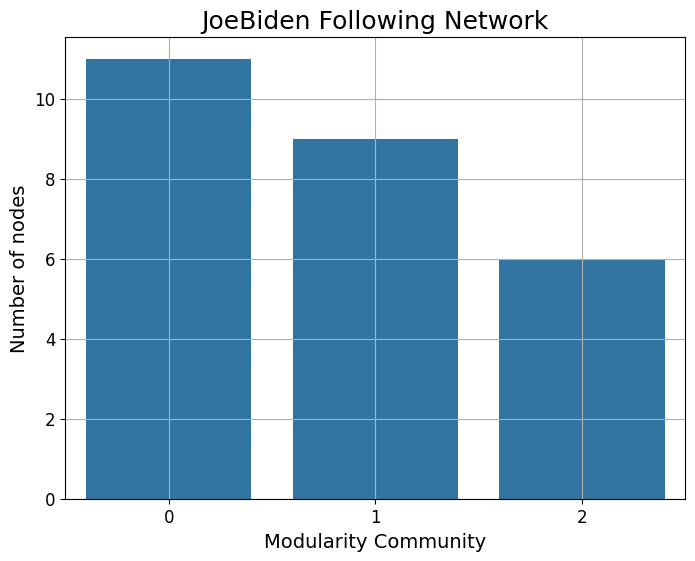

In [8]:
#plot modularity community sizes
sns.countplot(data=df, x="community_mod")
plt.xlabel("Modularity Community", fontsize = 14)
plt.ylabel("Number of nodes", fontsize = 14)
plt.title(f"{screen_name} Following Network", fontsize = 18)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.grid()
plt.show()

## Draw Network and Communities
We will draw the network and color the nodes by their community membership.  We can specify the node color for each community, node size, edge color, edge width, background color, and node position.  If you want to try other layout algorithms, check out this link:
https://networkx.org/documentation/stable/reference/drawing.html


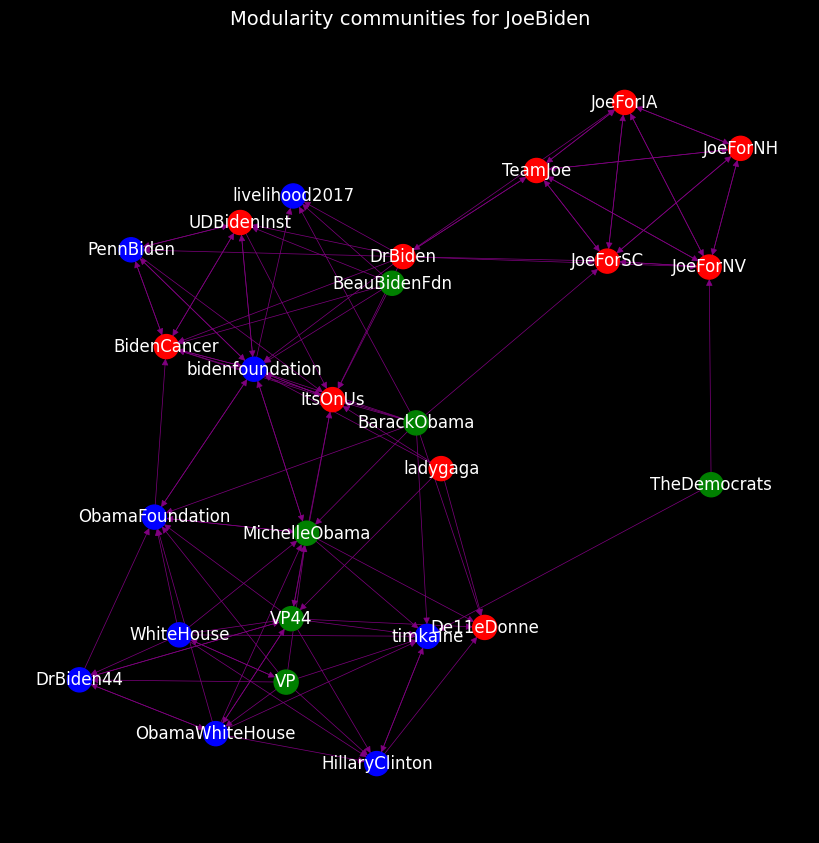

In [9]:
Colors = ['red','blue','green','orange','purple','pink',
          'brown','gray','cyan','magenta']

node_color = [Colors[df.community_mod[df.username==node].values[0]] for node in G.nodes()]
edge_color = 'purple'
background_color = 'black'
edge_width = 0.5
node_size = 300
pos = nx.kamada_kawai_layout(G)  #position of each node in the network

fig = plt.figure(figsize=(8,8))
nx.draw(G, pos, node_color = node_color,
        width= edge_width,
        edge_color=edge_color,
        node_size=node_size,
       with_labels=True,
        font_color = 'white')
fig.set_facecolor(background_color)
plt.title(f"Modularity communities for {screen_name}",color = 'white',fontsize = 14)
plt.show()

# Spectral Clustering Communities

We will find communities using spectral clustering.

## Find Spectral Clustering Communities

We will use the `spectral_clustering` function to find the spectral communities.  We have to select the number of communities, which we call `k`.  We will add a column `"community_spec"` to `df` that has the community membership of each node.



In [10]:
k = 3
df_spec = spectral_communities(G,k)
df_spec.rename(columns={'screen_name': 'username'}, inplace=True)
df = df.merge(df_spec, on='username', how='left').rename(columns={'community': 'community_spec'})

df.head()

username  community_mod  community_spec
0  JoeForNV              0               0
1  JoeForSC              0               0
2  JoeForNH              0               0
3  JoeForIA              0               0
4   TeamJoe              0               0

## Plot Spectral Clustering Community Sizes

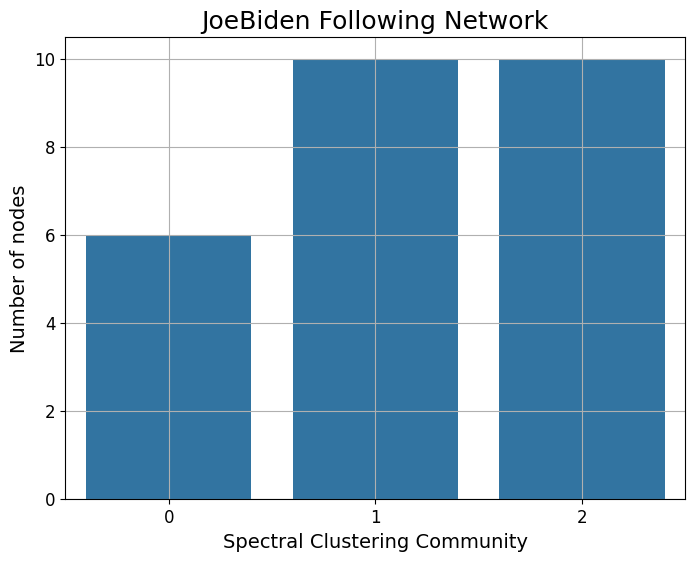

In [11]:
#plot spectral community sizes
sns.countplot(data=df, x="community_spec")
plt.xlabel("Spectral Clustering Community", fontsize = 14)
plt.ylabel("Number of nodes", fontsize = 14)
plt.title(f"{screen_name} Following Network", fontsize = 18)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.grid()
plt.show()

## Draw Network and Communities
We will draw the network and color the nodes by their community membership.  We can specify the node color for each community, node size, edge color, edge width, background color, and node position.

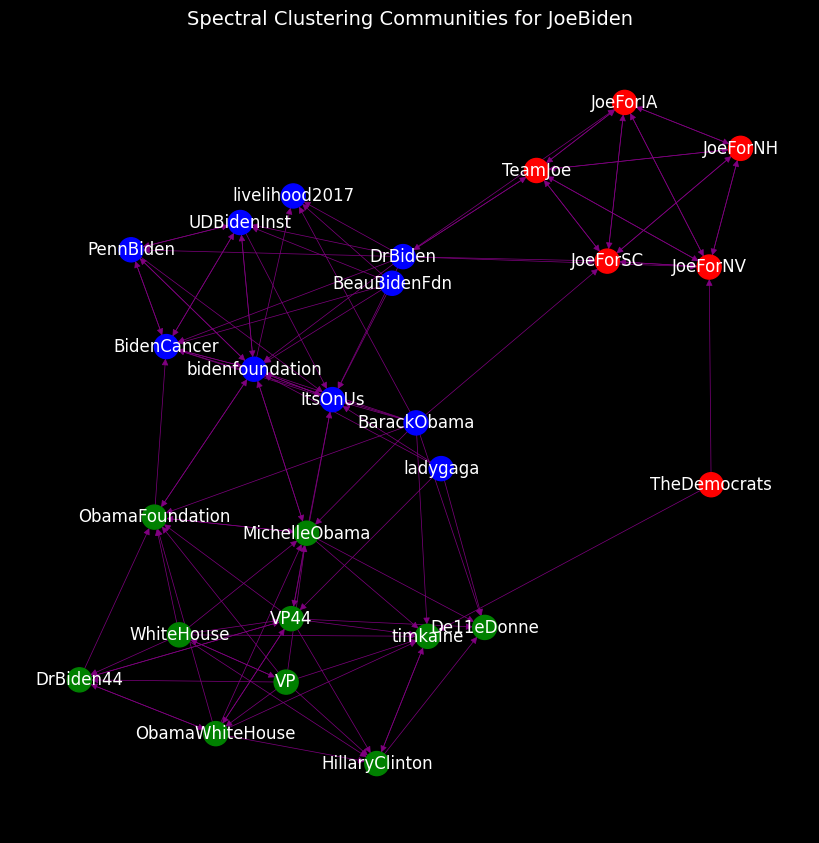

In [12]:
Colors = ['red','blue','green','orange','purple',
          'pink','brown','gray','cyan','magenta']

node_color = [Colors[df.community_spec[df.username==node].values[0]] for node in G.nodes()]
edge_color = 'purple'
background_color = 'black'
edge_width = 0.5
node_size = 300
pos = nx.kamada_kawai_layout(G)  #position of each node in the network

fig = plt.figure(figsize=(8,8))
nx.draw(G, pos, node_color = node_color,
        width= edge_width,
        edge_color=edge_color,
        node_size=node_size,
       with_labels=True,
        font_color = 'white')
fig.set_facecolor(background_color)
plt.title(f"Spectral Clustering Communities for {screen_name}",color = 'white',fontsize = 14)
plt.show()

# Find best spectral communities using modularity

## Compute modularity for different `k`

We will go through different values of `k` using a `for` loop and calculate the spectral communities.  We will calculate the modularity of these communities.  This requires us to convert the communities in the dataframe `df_spec` into a list of lists we call `C`.  Each list in `C` has the members of the community.  As we go through the values of `k` we will keep track of the value that gives the highest modularity.  We call this value `kbest` and the corresponding modularity is `mod_best`.

In [13]:
K = np.arange(1,10,1)
Mod = []
kbest = 0
mod_best = -1e10
for k in K:
    df_spec = spectral_communities(G,k)  #find spectral communities
    #create list of lists of community members
    C = []
    for community_index in df_spec.community.unique():
        community = df_spec.screen_name[df_spec.community==community_index].tolist()
        C.append(community)
    mod = nx_comm.modularity(G.to_undirected(), C)  #calculate modularity of communities
    Mod.append(mod)

    print(f"k={k}, modularity = {mod:.3f}")

    #keep track of the best modularity and corresponding k
    if mod>mod_best:
        mod_best = mod
        kbest = k

print(f"\nbest k = {kbest}, modularity = {mod_best:.2f}")

k=1, modularity = 0.000
k=2, modularity = 0.236
k=3, modularity = 0.427
k=4, modularity = 0.420
k=5, modularity = 0.412
k=6, modularity = 0.360
k=7, modularity = 0.321
k=8, modularity = 0.262
k=9, modularity = 0.232

best k = 3, modularity = 0.43


## Plot Modularity vs `k`

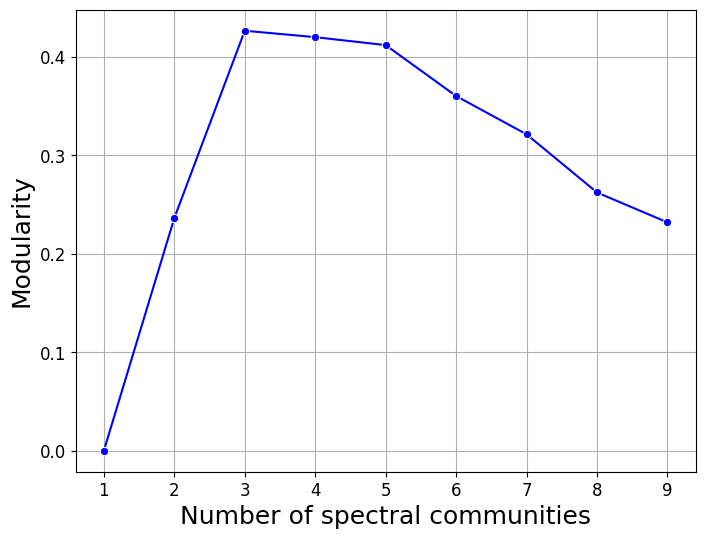

In [14]:
df_k_mod = pd.DataFrame({'k':K,'modularity':Mod})

fig = plt.figure(figsize = (8,6))
sns.lineplot(data = df_k_mod,
             x = 'k',
             y = 'modularity',
             marker = 'o',
             color = 'blue')
plt.xlabel("Number of spectral communities",fontsize = 18)
plt.ylabel("Modularity",fontsize = 18)
plt.grid()
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.show()

# Community Analysis

Now we will use the profile information about these users to determine the theme of each community.

## Load Profiles of Following

The information for the following of JoeBiden is in the file `"data/TwFollow/TwFollow_joebiden_following.csv"`.  We will load this into a dataframe `df_f` and merge it with `df`.

In [15]:
df_f = pd.read_csv('data/TwFollow/TwFollow_joebiden_following.csv')
df_f = df_f[~df_f.bio.isna()]  #remove any empty bios
df = df.merge(df_f, on='username', how='left')
df.columns = [col.split('_x')[0] if '_' in col else col for col in df.columns]  #clean up column names
df.columns = [col.split('_y')[0] if '_' in col else col for col in df.columns]  #clean up column names

df.head(2)

username  community_mod  community_spec            name  \
0  JoeForNV              0               0  Joe for Nevada   
1  JoeForSC              0               0        Joe Won.   

                  userId can_dm           created_at  \
0  '1141928541656952832'  False  2019-06-21 00:39:15   
1  '1141929375639777280'  False  2019-06-21 00:42:33   

                                                                                                                                       bio  \
0  The official account for our grassroots team working to elect @JoeBiden in Nevada. Text JOE to 30330 to get involved and join @TeamJoe!   
1                                              Organizing and mobilizing the Palmetto State for @JoeBiden 🌴 | Text SC to 30330 for updates   

   tweets_count  followers_count  following_count  favourites_count  \
0        3026.0          12128.0            867.0            4851.0   
1         640.0           9134.0            199.0             215.0   

       location  media_count  \
0        Nevada        612.0   
1  Columbia, SC        239.0   

                                                     profile_banner_url  \
0  https://pbs.twimg.com/profile_banners/1141928541656952832/1596463253   
1  https://pbs.twimg.com/profile_banners/1141929375639777280/1581692016   

                        profile_url  \
0  https://www.twitter.com/JoeForNV   
1  https://www.twitter.com/JoeForSC   

                                                                     avatar_url  \
0  https://pbs.twimg.com/profile_images/1157459791381331968/wdPfMRsC_normal.jpg   
1  https://pbs.twimg.com/profile_images/1162388438198489088/ajbU-t1r_normal.png   

  verified blue_verified  
0    False         False  
1    False         False

## Analyze Communities Using Text Data

We will feed the `"bio"`, `"followers_count"`, `"location"`,`"username"`, and `"name"` of each user in a community to ChatGPT and ask it to describe the community.  We will also ask it to identify representative members of the community.  We just need to set the name of the community column in the variable `community_type`.

In [16]:
instructions_community = '''Describe the common theme of this community
of Twitter users, and return the username of users which are representative
examples for this community.   You will be given the username, location,
followers count,  and bio of each user.
Return your answer in the format "prominent users": <username>,
"description":<description>. '''

community_type = 'community_spec'
print(community_type)
for cluster in df[community_type].unique():
  prompt = ""
  for index, row in df[df[community_type]==cluster].iterrows():
    prompt += f'username: {row.username},'
    prompt += f'location:{row.location},'
    prompt += f'bio:{row.bio}\n'
    prompt += f'follower count: {row.followers_count}'
  response = get_completion(prompt, instructions_community, client, MODEL)
  print(f"Community {cluster}:\n{tr.fill(response)}\n")

community_spec
Community 0:
"prominent users": "TeamJoe, TheDemocrats", "description": "This
community of Twitter users is centered around supporting and
organizing for Joe Biden and the Democratic Party. The accounts share
information, updates, and mobilization efforts related to Joe Biden's
campaign and Democratic Party initiatives."

Community 2:
"prominent users": ["ObamaFoundation", "HillaryClinton",
"MichelleObama"], "description": "This community consists of
influential political figures, organizations associated with U.S.
politics, and their relatives. It includes former office holders,
advocacy groups focused on civic engagement, and family members of
politicians, all actively involved in or connected to political
discourse and civic activism."

Community 1:
"prominent users": "ladygaga, BarackObama", "description": "This
community can be broadly characterized by its members' involvement in
various forms of advocacy, public service, and entertainment. Lady
Gaga represents the 

# Text Based Communities

We will ignore the network data and find communities by clustering embeddings of the text information about the nodes in the network.

## Compute Text Embeddings

We will combine the text data of each user (`"bio"`, `"location"`,`"username"`, and `"name"`) into a single string and call it `"text_data"` and embed this using the OpenAI Embeddings model.

In [17]:
df['text_data'] = df[['bio', 'location', 'username', 'name']].apply(lambda x: ' '.join(x.dropna().astype(str)), axis=1)

embedding_text = df['text_data'].progress_apply(get_embedding)



  0%|          | 0/26 [00:00<?, ?it/s]

## Compute Low-Dimensional Embeddings of Text Data

We will use both PCA and UMAP.  We can choose which one we want to use for finding communities.



In [18]:
T = np.stack(embedding_text, axis = 0)


pca = PCA(n_components=2)
pca_embedding = pca.fit_transform(T)

umap = UMAP(n_components=2)
umap_embedding = umap.fit_transform(T)

df['pca_x'] = pca_embedding[:,0]
df['pca_y'] = pca_embedding[:,1]
df['umap_x'] = umap_embedding[:,0]
df['umap_y'] = umap_embedding[:,1]

## Find Communities Using K-Means on Embeddings

Choose your `embedding_type` and then apply K-Means to find the communities.  We will use the silhouette score to determine the best number of communities.

K = 2, silhouette score = 0.342184841632843
K = 3, silhouette score = 0.4219551682472229
K = 4, silhouette score = 0.4294486343860626
K = 5, silhouette score = 0.3208599388599396
K = 6, silhouette score = 0.32773321866989136
K = 7, silhouette score = 0.36645862460136414
K = 8, silhouette score = 0.3033512830734253
K = 9, silhouette score = 0.28208044171333313
K = 10, silhouette score = 0.25835978984832764
K = 11, silhouette score = 0.22294923663139343
K = 12, silhouette score = 0.2282072752714157
K = 13, silhouette score = 0.20031052827835083
K = 14, silhouette score = 0.19347618520259857
K = 15, silhouette score = 0.17971442639827728
K = 16, silhouette score = 0.1554049402475357
K = 17, silhouette score = 0.13357295095920563
K = 18, silhouette score = 0.10800610482692719
K = 19, silhouette score = 0.1279217153787613
The silhouette optimal number of clusters (K) is: 4


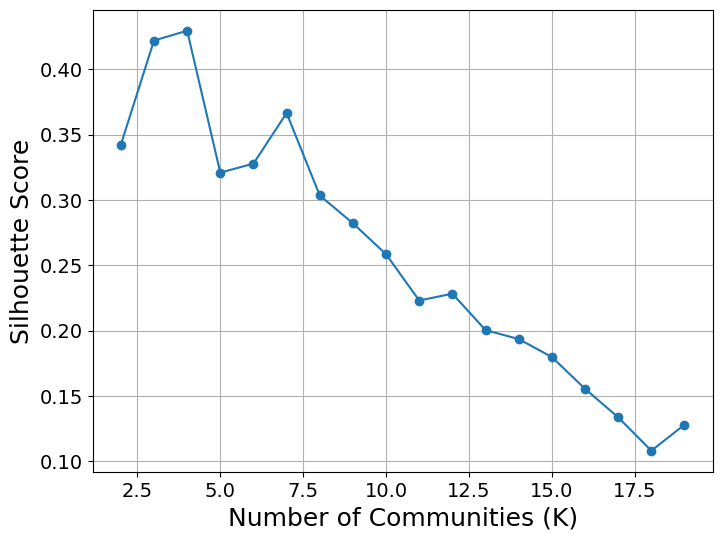

In [19]:
# Choose your embedding to cluster
embedding_name = 'umap'
embedding = df[[f'{embedding_name}_x', f'{embedding_name}_y']].to_numpy()

# Define the range of K values to try
K_range = range(2, 20)  # For example, trying K from 2 to 10

# Prepare a list to store silhouette scores
silhouette_scores = []

# Compute KMeans and silhouette score for each K
for K in K_range:
    kmeans = KMeans(n_clusters=K,
                    random_state=42,
                    n_init='auto')
    kmeans.fit(embedding)
    labels = kmeans.labels_
    silhouette_avg = silhouette_score(embedding, labels)
    silhouette_scores.append(silhouette_avg)
    print(f"K = {K}, silhouette score = {silhouette_avg}")

# Find the optimal K (number of clusters) with the highest silhouette score
optimal_K = K_range[silhouette_scores.index(max(silhouette_scores))]
print(f"The silhouette optimal number of clusters (K) is: {optimal_K}")
plt.plot(K_range, silhouette_scores,'o-')
plt.xlabel('Number of Communities (K)')
plt.ylabel('Silhouette Score')
plt.grid()
plt.show()


## Compute Text Based Communities with Optimal `k`

We will add a column `"community_text"` to `df` that has the text based communities.

In [20]:
optimal_K = 3
kmeans = KMeans(n_clusters=optimal_K,
                random_state=42,
                n_init='auto')
kmeans.fit(umap_embedding)
df['community_text'] = kmeans.labels_

## Plot Text Embedding Communities

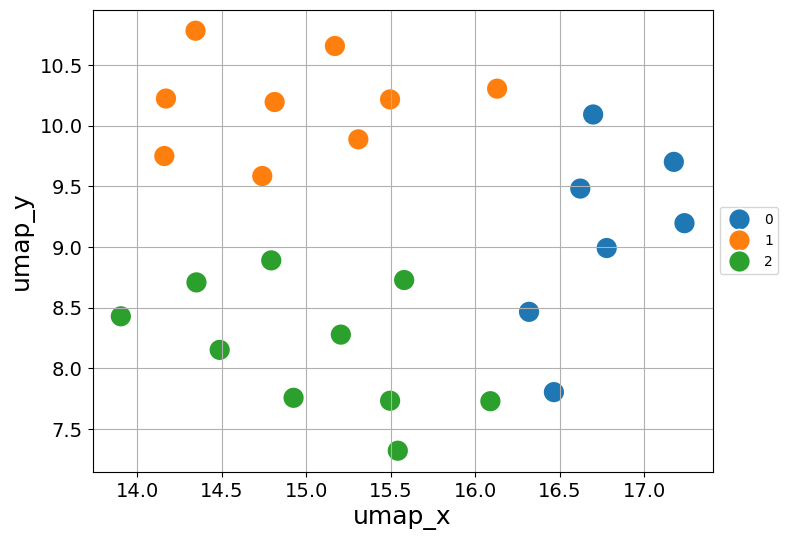

In [21]:
embedding_type = 'umap'
s = 250

#plot the user description embedding
sns.scatterplot(x=f'{embedding_type}_x',
                y=f'{embedding_type}_y',
                data=df,
                marker = 'o',
                hue = 'community_text',
                palette = 'tab10',
                s = s)
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## Interactive Text Embeddings Plot

In [22]:
embedding_type = 'umap'

xcol = f'{embedding_type}_x'
ycol = f'{embedding_type}_y'
huecol = 'community_text'
# Create a scatter plot
fig = px.scatter(df, x=xcol, y=ycol,
                 hover_name='username',
                 hover_data={'username': True},
                 color = huecol,
                 size = 10*np.ones(len(df))
                 )

# Add titles and labels

fig.update_layout(title=f"Text Embedding Communities for {screen_name}",
                  xaxis_title=xcol,
                  yaxis_title=ycol,
                  width=800,  # width in pixels
                  height=600)

# Show the plot
fig.show()


## Analyze Communities

Set `community_type` to `"community_text"` and have ChatGPT analyze the communities.  We combine the relevant columns in `df` together for each user in the community and put this in the `prompt`.

In [23]:
instructions_community = '''Describe the common theme of this community
of Twitter users, and return the username of users which are representative
examples for this community.   You will be given the username, location,
followers count,  and bio of each user.
Return your answer in the format "prominent users": <username>,
"description":<description>. '''

community_type = 'community_text'
print(community_type)
for cluster in df[community_type].unique():
  prompt = ""
  for index, row in df[df[community_type]==cluster].iterrows():
    prompt += f'username: {row.username},'
    prompt += f'location:{row.location},'
    prompt += f'bio:{row.bio}\n'
    prompt += f'follower count: {row.followers_count}'
  response = get_completion(prompt, instructions_community, client, MODEL)
  print(f"Community {cluster}:\n{tr.fill(response)}\n")

community_text
Community 0:
"prominent users": "TeamJoe, JoeForNV, JoeForSC, JoeForNH, JoeForIA",
"description": "This community consists of Twitter users actively
involved in the grassroots campaign and organizing efforts to support
Joe Biden's electoral campaigns. These accounts share a common purpose
in mobilizing and organizing support across various states for Joe
Biden, emphasizing grassroots involvement and providing updates on how
to get involved with the campaign."

Community 2:
"prominent users": "BarackObama, MichelleObama, HillaryClinton,
DrBiden", "description": "Prominent figures associated with United
States politics, including former Presidents and First Ladies, as well
as significant political figures and their related official/archived
accounts. The community involves those who have been directly involved
in U.S. governance or have had a significant impact on political
discourse."

Community 1:
"prominent users": ItsOnUs, UDBidenInst, BidenCancer, PennBiden,
ObamaFoun

# Image Based Communities

We will ignore the network data and find communities by clustering embeddings of the profile pictures of the nodes in the network.

## Embed Profile Pictures

The profile pictures of the accounts are in the `"avatar_url"` column.  We will use ResNet50 to embed these images.  This code was written totally by AI.

In [24]:
image_urls = df['avatar_url'].tolist()



# Function to preprocess image for ResNet50
def preprocess_image(image):
    image = tf.image.resize(image, (224, 224))  # Resize image to match ResNet50 input size
    image = tf.keras.applications.resnet50.preprocess_input(image)  # Preprocess image for ResNet50
    return image

# Load ResNet50 model from TensorFlow Hub
resnet_model = hub.load("https://tfhub.dev/google/imagenet/resnet_v1_50/feature_vector/4")

# Initialize list to store image embeddings
image_embeddings = []

# Loop through image URLs with tqdm progress bar
for url in tqdm(image_urls, desc="Downloading and computing embeddings"):
    try:
        response = requests.get(url)
        image = Image.open(BytesIO(response.content))  # Open image from response content
        image = np.array(image)  # Convert image to numpy array
        image = preprocess_image(image)  # Preprocess image for ResNet50
        image_embedding = resnet_model(tf.expand_dims(image, axis=0)).numpy()  # Compute ResNet50 embedding
        image_embeddings.append(image_embedding)
    except Exception as e:
        image_embeddings.append(np.full((1, 2048), np.nan))
        print(f"Error processing image from URL {url}: {e}")

# Convert list of embeddings to numpy array
image_embeddings = np.array(image_embeddings)
image_embeddings = image_embeddings.reshape(-1, 2048)



Error processing image from URL https://pbs.twimg.com/profile_images/1162388438198489088/ajbU-t1r_normal.png: {{function_node __wrapped__BiasAdd_device_/job:localhost/replica:0/task:0/device:CPU:0}} Must provide as many biases as the last dimension of the input tensor: [3] vs. [224,224,4] [Op:BiasAdd] name: 


Error processing image from URL https://pbs.twimg.com/profile_images/1120783776928403456/vnvqAGgP_normal.png: {{function_node __wrapped__BiasAdd_device_/job:localhost/replica:0/task:0/device:CPU:0}} Must provide as many biases as the last dimension of the input tensor: [3] vs. [224,224,4] [Op:BiasAdd] name: 


Error processing image from URL nan: Invalid URL 'nan': No scheme supplied. Perhaps you meant https://nan?


## Compute Low-Dimensional Embeddings of Image Data

In [25]:
image_embeddings_cleaned = image_embeddings[~np.isnan(image_embeddings).any(axis=1)]

pca = PCA(n_components=2)
pca_embedding = pca.fit_transform(image_embeddings_cleaned)

umap = UMAP(n_components=2)
umap_embedding = umap.fit_transform(image_embeddings_cleaned)

# Assign PCA embeddings where available
df.loc[~np.isnan(image_embeddings).any(axis=1), 'image_pca_x'] = pca_embedding[:, 0]
df.loc[~np.isnan(image_embeddings).any(axis=1), 'image_pca_y'] = pca_embedding[:, 1]
df.loc[~np.isnan(image_embeddings).any(axis=1), 'image_umap_x'] = umap_embedding[:, 0]
df.loc[~np.isnan(image_embeddings).any(axis=1), 'image_umap_y'] = umap_embedding[:, 1]
df_image = df[~np.isnan(image_embeddings).any(axis=1)].dropna()


## ## Compute Image Based Communities

We will add a column `"community_image"` to `df` that has the image based communities.

In [26]:
optimal_K = 3
kmeans = KMeans(n_clusters=optimal_K,
                random_state=42,
                n_init='auto')
kmeans.fit(df_image[['image_umap_x', 'image_umap_y']].to_numpy())
df_image['community_image'] = kmeans.labels_

## Plot Image Embedding Communities

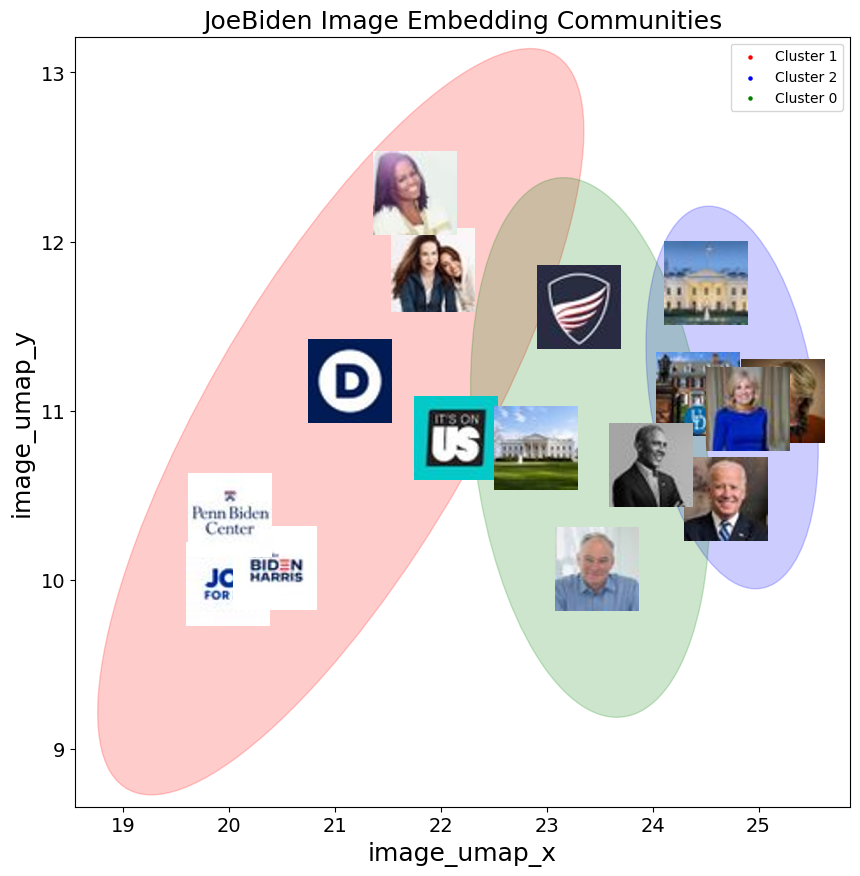

In [27]:
col_x = 'image_umap_x'
col_y = 'image_umap_y'
col_image_url = 'avatar_url'

ax = plot_image_embedding(df_image, col_x,col_y,col_image_url,
                         image_zoom = 0.3,
                         max_size = 200)

# Plot ellipses for each cluster
ellipse_scale = 5

Colors  = ['red','blue','green','orange','purple','pink',
          'brown','gray','cyan','magenta']
for k, col in zip(df_image['community_image'].unique(), Colors):
    data_k = df_image[df_image['community_image'] == k]
    x_k, y_k = data_k[col_x], data_k[col_y]
    ax.scatter(x_k, y_k, s=5, color=col, label=f'Cluster {k}')

    # Calculate the mean and covariance matrix for the cluster
    cov = np.cov(x_k, y_k)
    draw_ellipse([np.mean(x_k), np.mean(y_k)], cov,
                 ax=ax,
                 ellipse_scale = ellipse_scale,
                 alpha=0.2, color=col)

ax.legend()



# Set axis labels
plt.xlabel(col_x)
plt.ylabel(col_y)
plt.title(f'{screen_name} Image Embedding Communities')
# Show the plot
plt.show()


## Analyze Communities

We will use Vision to analyze the image based communities with the `generate_image_description` function.

community_image


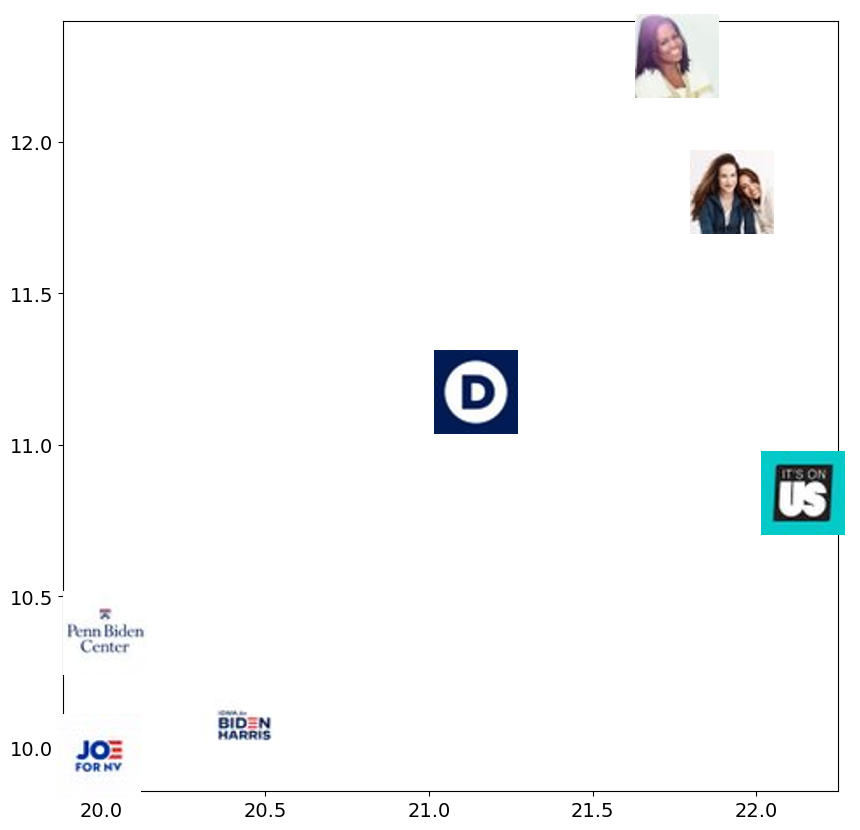

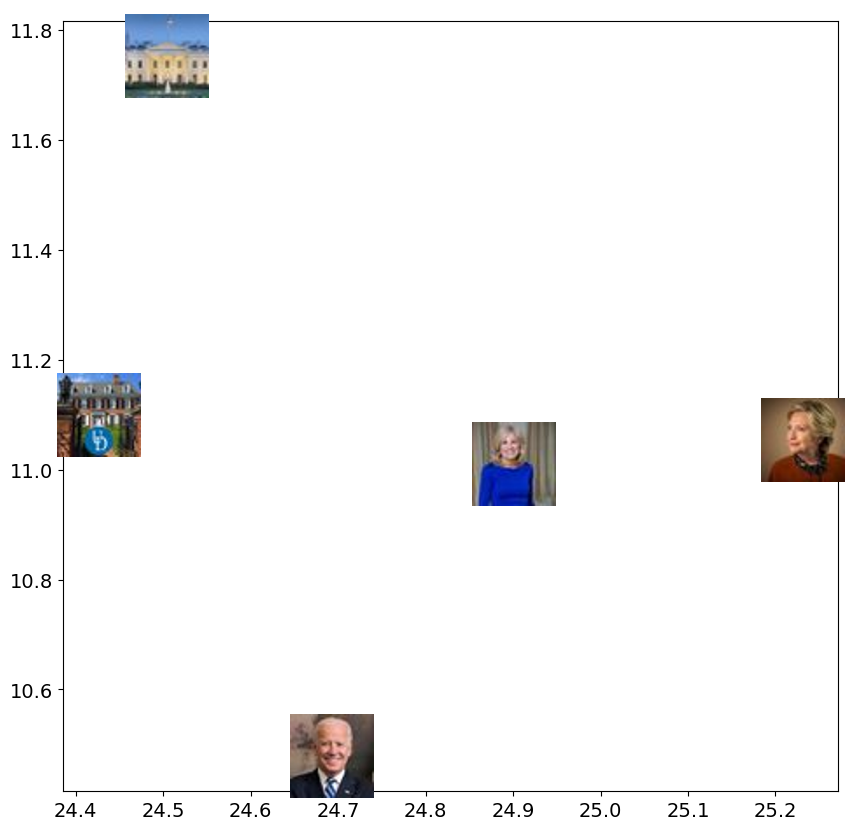

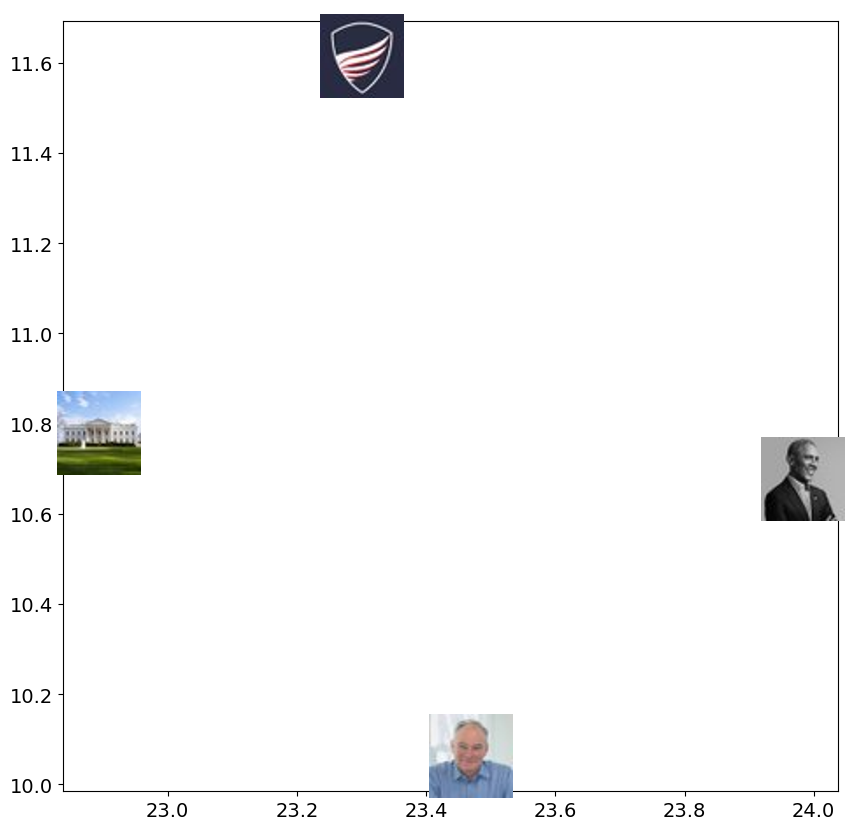

In [28]:
instructions_community_image = '''Describe the common theme of this cluster
of images and give the cluster a title.
Return your answer in the format "title": <title>,
"description":<description>. '''

community_type = 'community_image'
col_x = 'image_umap_x'
col_y = 'image_umap_y'
col_image_url = 'avatar_url'

print(community_type)
for cluster in df_image[community_type].unique():
  image_urls = df_image[df_image[community_type] == cluster]['avatar_url'].tolist()
  response = generate_image_description(image_urls,
                                        instructions_community_image)
  display(HTML(response))
  ax = plot_image_embedding(df_image[df_image[community_type]==cluster],
                            col_x,col_y,
                            col_image_url,
                          image_zoom = 0.3,
                          max_size = 200)
  plt.show()

# AI Communities

Why even bother to embed the data?  Let's just give the AI all the information we have about the users and have it find the communities.

## Text Based AI Communities

To start, we will give all the text information in the profiles of these users to the AI and have it find the communities and describe them to us.  We will put all the profile information in a string `profiles`.  Then we will use the `instructions_text` instructions and `get_completion` function to get the communities.

In [29]:
profiles = ''
for index, row in df.iterrows():
  profile = f'USERNAME: {row.username},'
  profile += f'NAME:{row.name},'
  profile += f'FOLLOWERS_COUNT: {row.followers_count},'
  profile += f'LOCATION:{row.location},'
  profile += f'BIOGRAPHY:{row.bio}\n'

  profiles += profile

In [30]:
instructions_text = f'''Cluster the users with this information.
You will be given the username, name, location, followers count,
and bio of each user.
Give each cluster a title, a short description, and list some
representative users.
Return your answer in HTML table with format
"title": <title>,
"representative users": <representative users>,
"description":<description>.
Return only the HTML code.
'''

response_text = get_completion(profiles, instructions_text, client, MODEL)
display(HTML(response_text))


## Image Based AI Communities

We will put all the profile picture urls, which are in the column `"avatar_url"` in `df`, into a list `image_urls`, and then get the communities using the `instructions_images` instructions and the `generate_image_description` function.

In [31]:
image_urls = df['avatar_url'].dropna().tolist()
instructions_images = '''Cluster this set of images.
Give each cluster a title and a short description.
Return your answer in HTML table with format
"title": <title>,
"description":<description>.
Return only the HTML code.'''
response_image = generate_image_description(image_urls,
                                      instructions_images)
display(HTML(response_image))


## Text and Image AI Communities

Let' combine the text and image data and see what kind of communities we get.  We will need to use Vision (`generate_image_description` function) for this.

In [32]:
image_urls = df['avatar_url'].dropna().tolist()
instructions_text_images = f'''Cluster this data, which is
images plus text.
Give each cluster a title, a short description, and list some
representative users.
Return your answer in HTML table with format
"title": <title>,
"representative users": <representative users>,
"description":<description>.
Return only the HTML code.\n
'''
instructions_text_images += profiles


response_text_image = generate_image_description(image_urls,
                                      instructions_text_images)
display(HTML(response_text_image))

# Targeting Content Based on Communities

## Targeting with Text Content Based on Communities

Lets create some targeted content for this user based on their community analysis.  Just pick your `"topic"` you want to persuade them on and the `content` you want to perusade with (text content only).



In [33]:
topic = '''You should buy a Tesla car.'''
content = 'tweet'

instructions = f'''You will be given a description of the communities
a fictitious person is interested in.  These communities describe this persons
interests and preferences.
Convince this person to support {topic} with a {content}.
Dont directly mention the information about the target in the message.
Be more subtle as that makes the persuasion more effective. '''

description = response_text_image
prompt = f'''Community descriptions:\n{description}.'''
tweet = get_completion(prompt, instructions,client,MODEL)

tweet_html = display_tweet(tweet)




## Targeting With Other Text Content

For text content, you can also try

1. Tweet

2. Sales pitch

3. Email sales pitch

4. Song

5. Tiktok video narration

In [34]:
topic = '''You should buy a Tesla car.'''
content = 'in person sales pitch'

instructions = f'''You will be given a description of the communities
a fictitious person is interested in.  These communities describe this persons
interests and preferences.
Convince this person to support {topic} with a {content}.
Dont directly mention the information about the target in the message.
Be more subtle as that makes the persuasion more effective.
Return the answer as an easy to read and nicely formatted HTML.'''

description = response_text_image
prompt = f'''Community descriptions:\n{description}.'''
content = get_completion(prompt, instructions,client,MODEL)

display(HTML(content))



## Targeting with Image Content Based on Communities


Imagine this: A sleek, timeless Tesla car parked in front of a
beautifully lit, historic government building at dusk. The electric
vehicle, symbolizing innovation and progress, stands out against the
backdrop of tradition and history. Just above the car, the sky melts
into hues of purple and orange, a perfect blend of day and night.
Captured in this single frame is a message of moving forward while
respecting our past.   In the foreground, the Tesla car is not just a
car; it’s a statement. It says that technology, sustainability, and
forward-thinking are not just ideas of the future but are here,
merging seamlessly with our daily lives and values. The electric glow
from the vehicle's headlights and the soft reflection of the setting
sun on its body hint at the promise of a cleaner, brighter future.
This image, shared for the world to see, carries with it a subtle nod
to the values of progress, unity, and responsibility towards the
environment. It's a gentle reminder that choices like 


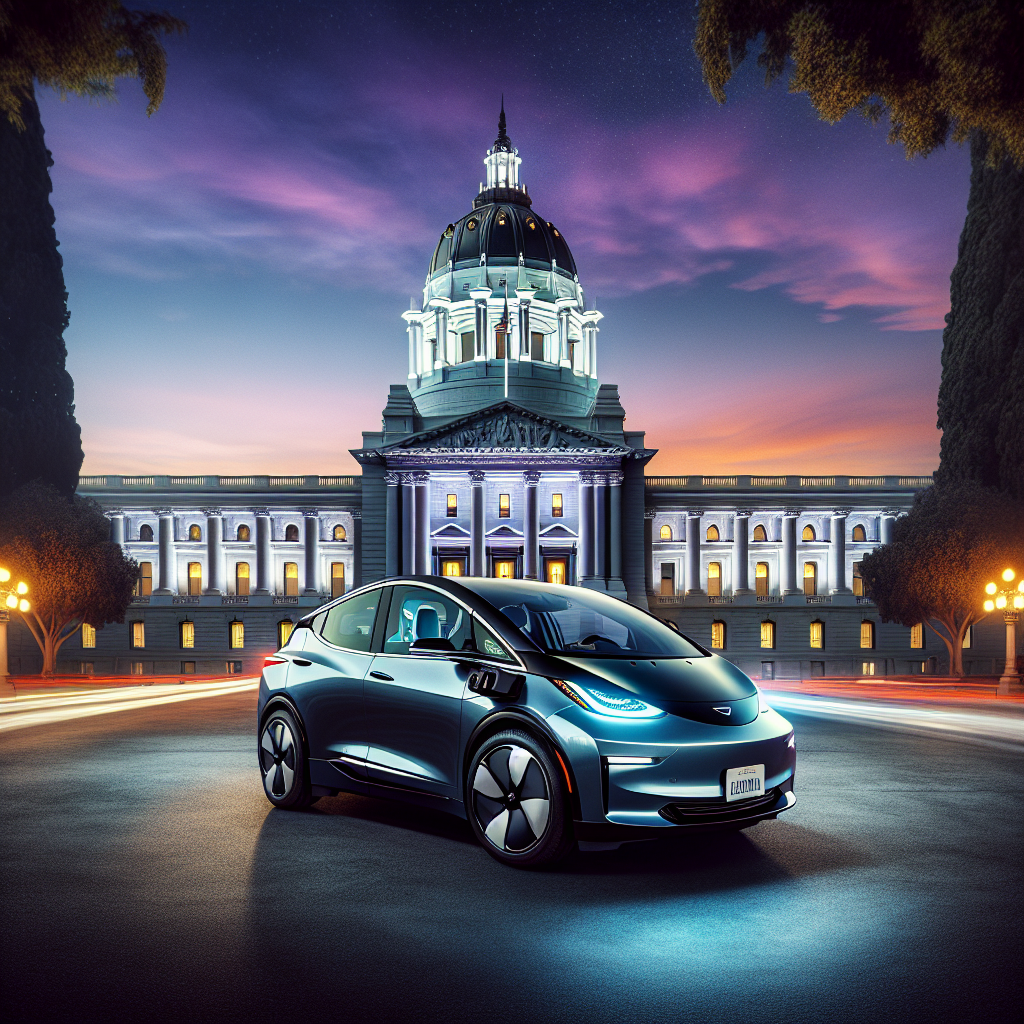

In [35]:
content = "description of an image to be posted to Instagram."

instructions = f'''You will be given a description of the communities
a fictitious person is interested in.  These communities describe this persons
interests and preferences.
Convince them to support {topic} with a {content}.
Dont directly mention the information about the target in the message.
Be more subtle as that makes the persuasion more effective. '''

instructions_caption = f'''Write an Instagram caption for this image
that will convince a person interested in these communities:
<{prompt}>,\n
to support this topic: {topic}.
Return only the caption.'''

description = response_text_image


prompt = f'''Community descriptions:\n{description}.'''

#The AI is puttin in work
image_prompt = get_completion(prompt, instructions,client,MODEL)
image_url, revised_prompt = generate_image(image_prompt)
caption = generate_image_description(image_urls, instructions_caption)


print(f"\n{tr.fill(image_prompt)}")
ig_html = display_IG(caption, image_url);